# fMRI 1st level analysis

Individual (1st level) analysis -adapted from nipype tutorial  https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html and https://miykael.github.io/nipype_tutorial/notebooks/handson_analysis.html

In this analysis workflow we will:

1. Extract stimuli time from json files (BIDs)
2. Specify the 1st level GLM (General Linear Model)
3. Specify Contrasts to compute
4. Estimate contrasts (in this example: con_0001:NF vs REST [0 1], con_0002 NF>REST [-1 1] 
5. Normalize contrasts

## Imports 

In [1]:
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Normalize12
tpm_img ='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii' # normalization template

from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
from bids.layout import BIDSLayout
from nipype.algorithms.misc import Gunzip

import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat

191108-10:24:39,491 nipype.utils INFO:
	 Running nipype version 1.2.3 (latest: 1.2.3)


## Experiments parameters
(get metadata from BIDs json files)

In [18]:
data_dir='/home/ubuntu/Documents/BIDs/XP2'
experiment_dir='/home/ubuntu/Documents/windowshare/output/XP2'
output_dir='datasink'
working_dir='workingdir'

subject_list=['xp204','xp205','xp210','xp212','xp213','xp215','xp216','xp217','xp221','xp223']
#subject_list_1D=['xp201',xp202','xp203','xp206','xp208','xp209','xp211','xp214','xp218','xp219','xp220','xp222']

task_list=['1dNF']
run_list=['01','02','03']
fwhm=[6]

#FIND INFO FROM BIDS LAYOUT
func_file='/home/ubuntu/Documents/BIDs/XP2/sub-%s/func/sub-%s_task-%s_run-%s_bold.nii.gz' % (subject_list[0],subject_list[0],task_list[0],run_list[0])
layout_data=BIDSLayout(data_dir)
#sub_list=layout_data.get_subjects()
layout_data.get_tasks()
TR=layout_data.get_metadata(func_file)["RepetitionTime"]



KeyError: 'RepetitionTime'

## get stimuli info

In [3]:
import pandas as pd
trialinfo = pd.read_table('/home/ubuntu/Documents/BIDs/XP2/task-%s_events.tsv' % task_list[0])
trialinfo

,onset,duration,trial_type,stim_file
0,2,20,Rest,stimuli/Rest_Xp2.png
1,22,20,Task-NF,stimuli/Task-1dNF_Xp2.png
2,42,20,Rest,stimuli/Rest_Xp2.png
3,62,20,Task-NF,stimuli/Task-1dNF_Xp2.png
4,82,20,Rest,stimuli/Rest_Xp2.png
5,102,20,Task-NF,stimuli/Task-1dNF_Xp2.png
6,122,20,Rest,stimuli/Rest_Xp2.png
7,142,20,Task-NF,stimuli/Task-1dNF_Xp2.png
8,162,20,Rest,stimuli/Rest_Xp2.png
9,182,20,Task-NF,stimuli/Task-1dNF_Xp2.png


In [4]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch

    trialinfo = pd.read_table('/home/ubuntu/Documents/BIDs/XP2/task-2dNF_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset)) # subtracting 10s from onset due to removing of 4 dummy scans NO! NO DUMMY SCANS!!
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource


# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [5]:
subjectinfo(subject_list[0])

[Bunch(conditions=['Rest', 'Task-NF'],
       durations=[[20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20]],
       onsets=[[2, 42, 82, 122, 162, 202, 242, 282],
        [22, 62, 102, 142, 182, 222, 262, 302]])]

## Specify contrasts

In [6]:
# Condition names
condition_names = ['Rest', 'Task-NF']

# Contrasts
cont01 = ['NF-only',        'T', condition_names, [0, 1]]
cont02 = ['NF>Rest',         'T', condition_names, [-1, 1]]

contrast_list = [cont01, cont02]


## Specify Nodes 

In [7]:
#gunzip (SPM only reads unzipped files)
gunzip_func = Node(Gunzip(), name='gunzip_func')
gunzip_anat = Node(Gunzip(), name='gunzip_anat')

# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")



## normalize contrast

Normalize contrasts in common reference space by normalizing them to to the SPM12 tissue probability map TPM.nii and using SPM12's Normalize routine

At this step, you can also specify the voxel resolution of the output volumes (i.e. voxel resolution to 4x4x4mm).


In [8]:
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=tpm_img,
                             write_voxel_sizes=[2, 2, 2]
                            ),
                 name="normalize")

## Input and Output 

In [9]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'zrun_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                         ('zrun_id',run_list)
                       ]

# SelectFiles - to grab the data (alternative to DataGrabber)
templates = { 'anat': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}','run-{zrun_id}',
                         'sub-{subject_id}_T1w_brain.nii.gz'),
              'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}','run-{zrun_id}',
                         'fwhm-{fwhm_id}sub-{subject_id}_task-{task_id}_run-{zrun_id}_bold.nii.gz'),
              'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}','run-{zrun_id}',
                            'sub-{subject_id}_task-{task_id}_run-{zrun_id}_bold.par'),
             'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}','run-{zrun_id}',
                            'art.sub-{subject_id}_task-{task_id}_run-{zrun_id}_bold_outliers.txt')}


selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = task_list[0];
selectfiles.inputs.fwhm_id=6;

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_','sub-'),
              ('_zrun_id_','run-')]

subjFolders=[('run-%s/' % f, '/run-%s-' % f) for f in run_list]
             
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## workflow

In [10]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)


# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('zrun_id','zrun_id')]),
                    (selectfiles,gunzip_func,[('func', 'in_file')]),
                    (selectfiles, gunzip_anat, [('anat', 'in_file')]),
                    (gunzip_anat, normalize, [('out_file', 'image_to_align')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (gunzip_func, modelspec, [('out_file', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    (level1conest, normalize, [('con_images',
                                                 'apply_to_files')]),
                    (normalize, datasink, [('normalized_files', 'normalized.@files'),
                                            ('normalized_image', 'normalized.@image')])
                                      
                     ])
            

## visualize workflow

191108-10:24:45,853 nipype.workflow INFO:
	 Generated workflow graph: /home/ubuntu/Documents/windowshare/output/XP2/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


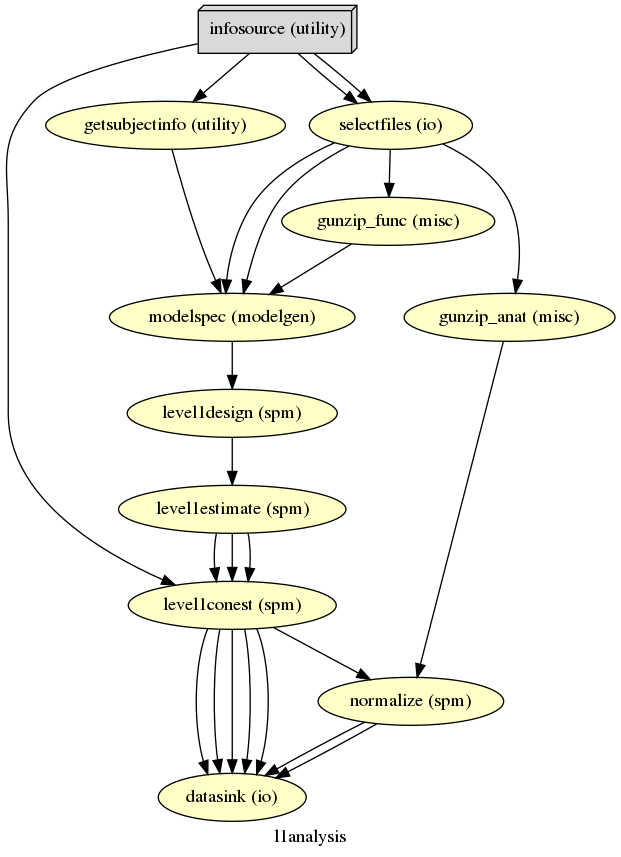

In [11]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))


## run workflow

In [12]:


l1analysis.run()



191108-10:24:45,917 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
191108-10:24:46,58 nipype.workflow INFO:
	 Running serially.
191108-10:24:46,60 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/ubuntu/Documents/windowshare/output/XP2/workingdir/l1analysis/_subject_id_xp209_zrun_id_03/getsubjectinfo".
191108-10:24:46,92 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
191108-10:24:46,134 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
191108-10:24:46,137 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/ubuntu/Documents/windowshare/output/XP2/workingdir/l1analysis/_subject_id_xp209_zrun_id_03/selectfiles".
191108-10:24:46,171 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
191108-10:24:46,225 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".


191108-10:34:20,847 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
191108-10:34:20,849 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/ubuntu/Documents/windowshare/output/XP2/workingdir/l1analysis/_subject_id_xp209_zrun_id_02/level1design".
191108-10:34:21,910 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
191108-10:35:37,189 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
191108-10:35:37,192 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/ubuntu/Documents/windowshare/output/XP2/workingdir/l1analysis/_subject_id_xp209_zrun_id_02/level1estimate".
191108-10:35:37,439 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
191108-10:36:39,857 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
191108-10:36:39,859 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest"

191108-10:50:05,463 nipype.interface INFO:
	 sub: /home/ubuntu/Documents/windowshare/output/XP2/datasink/normalized/_subject_id_xp209_zrun_id_01/wcon_0002.nii -> /home/ubuntu/Documents/windowshare/output/XP2/datasink/normalized/sub-xp209/run-01-wcon_0002.nii
191108-10:50:05,494 nipype.interface INFO:
	 sub: /home/ubuntu/Documents/windowshare/output/XP2/datasink/normalized/_subject_id_xp209_zrun_id_01/wsub-xp209_T1w_brain.nii -> /home/ubuntu/Documents/windowshare/output/XP2/datasink/normalized/sub-xp209/run-01-wsub-xp209_T1w_brain.nii
191108-10:50:05,522 nipype.interface INFO:
	 sub: /home/ubuntu/Documents/windowshare/output/XP2/datasink/1stLevel/_subject_id_xp209_zrun_id_01/SPM.mat -> /home/ubuntu/Documents/windowshare/output/XP2/datasink/1stLevel/sub-xp209/run-01-SPM.mat
191108-10:50:05,635 nipype.interface INFO:
	 sub: /home/ubuntu/Documents/windowshare/output/XP2/datasink/1stLevel/_subject_id_xp209_zrun_id_01/spmT_0001.nii -> /home/ubuntu/Documents/windowshare/output/XP2/datasink/1s

In [13]:
# visualize folder tree

!tree /home/ubuntu/Documents/windowshare/output/XP2/datasink/1stLevel


/home/ubuntu/Documents/windowshare/output/XP2/datasink/1stLevel
├── sub-xp201
│   ├── run-01-con_0001.nii
│   ├── run-01-con_0002.nii
│   ├── run-01-SPM.mat
│   ├── run-01-spmT_0001.nii
│   ├── run-01-spmT_0002.nii
│   ├── run-02-con_0001.nii
│   ├── run-02-con_0002.nii
│   ├── run-02-SPM.mat
│   ├── run-02-spmT_0001.nii
│   ├── run-02-spmT_0002.nii
│   ├── run-03-con_0001.nii
│   ├── run-03-con_0002.nii
│   ├── run-03-SPM.mat
│   ├── run-03-spmT_0001.nii
│   └── run-03-spmT_0002.nii
├── sub-xp202
│   ├── run-01-con_0001.nii
│   ├── run-01-con_0002.nii
│   ├── run-01-SPM.mat
│   ├── run-01-spmT_0001.nii
│   ├── run-01-spmT_0002.nii
│   ├── run-02-con_0001.nii
│   ├── run-02-con_0002.nii
│   ├── run-02-SPM.mat
│   ├── run-02-spmT_0001.nii
│   ├── run-02-spmT_0002.nii
│   ├── run-03-con_0001.nii
│   ├── run-03-con_0002.nii
│   ├── run-03-SPM.mat
│   ├── run-03-spmT_0001.nii
│   └── run-03-spmT_0002.nii
├── sub-xp203
│   ├── run-01-con_0001.nii
│   ├── run-01-con_0002.nii
│   ├── run-01-S

├── sub-xp218
│   ├── run-01-con_0001.nii
│   ├── run-01-con_0002.nii
│   ├── run-01-SPM.mat
│   ├── run-01-spmT_0001.nii
│   ├── run-01-spmT_0002.nii
│   ├── run-02-con_0001.nii
│   ├── run-02-con_0002.nii
│   ├── run-02-SPM.mat
│   ├── run-02-spmT_0001.nii
│   ├── run-02-spmT_0002.nii
│   ├── run-03-con_0001.nii
│   ├── run-03-con_0002.nii
│   ├── run-03-SPM.mat
│   ├── run-03-spmT_0001.nii
│   └── run-03-spmT_0002.nii
├── sub-xp219
│   ├── run-01-con_0001.nii
│   ├── run-01-con_0002.nii
│   ├── run-01-SPM.mat
│   ├── run-01-spmT_0001.nii
│   ├── run-01-spmT_0002.nii
│   ├── run-02-con_0001.nii
│   ├── run-02-con_0002.nii
│   ├── run-02-SPM.mat
│   ├── run-02-spmT_0001.nii
│   └── run-02-spmT_0002.nii
├── sub-xp220
│   ├── run-01-con_0001.nii
│   ├── run-01-con_0002.nii
│   ├── run-01-SPM.mat
│   ├── run-01-spmT_0001.nii
│   ├── run-01-spmT_0002.nii
│   ├── run-02-con_0001.nii
│   ├── run-02-con_0002.nii
│   ├── run-02-SPM.mat
│   ├── run-02-spmT_0001.nii
│   ├── run-02-spmT_0002.nii

# Visualize results 

 Visualize design matrix

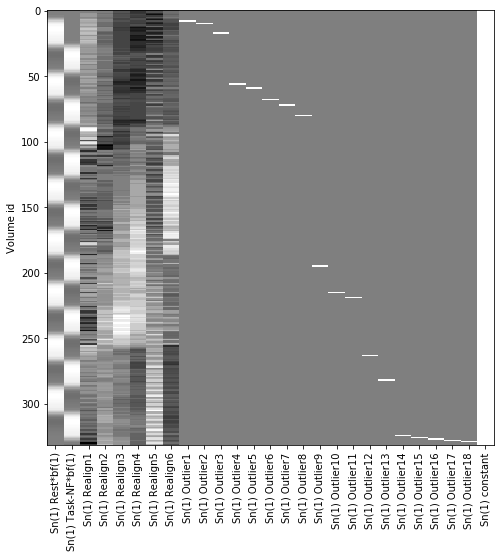

In [14]:
spmmat = loadmat('/home/ubuntu/Documents/windowshare/output/XP2/datasink/1stLevel/sub-%s/run-%s-SPM.mat' % (subject_list[0], run_list[0]),
                 struct_as_record=False)

#normalize all regressors for visualisation purpose
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)
# plot design matrix
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

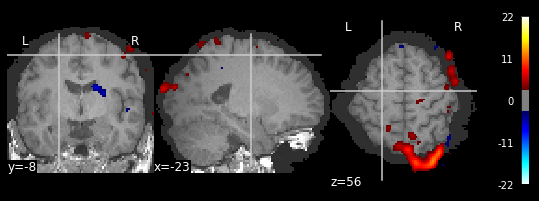

In [29]:
from nilearn.plotting import plot_stat_map, plot_glass_brain, plot_anat

anatimg = '/home/ubuntu/Documents/windowshare/output/XP2/datasink/normalized/sub-%s/run-%s-wsub-%s_T1w_brain.nii' %(subject_list[8],run_list[1],subject_list[8])
plot_stat_map(
    '/home/ubuntu/Documents/windowshare/output/XP2/datasink/normalized/sub-%s/run-%s-wcon_0002.nii' %(subject_list[8],run_list[1]),
    bg_img=anatimg, threshold=3, display_mode='ortho', cut_coords=(-23,-8,56), dim=-1);

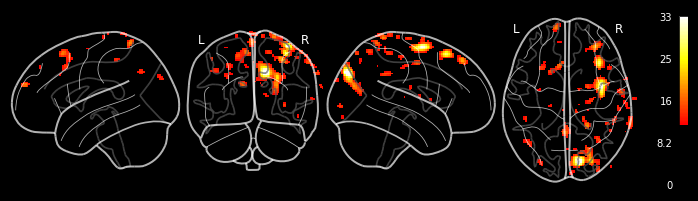

In [28]:
plot_glass_brain('/home/ubuntu/Documents/windowshare/output/XP2/datasink/normalized/sub-%s/run-%s-wcon_0001.nii' %(subject_list[7],run_list[1]),
                 colorbar=True, display_mode='lyrz', black_bg=True, threshold=12,
                 title='');

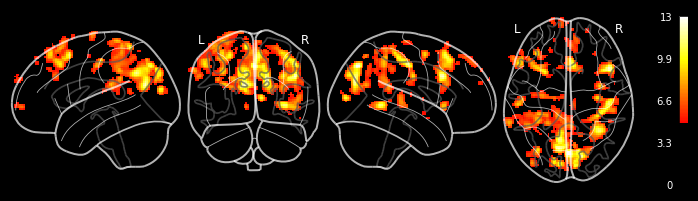

In [17]:
plot_glass_brain('/home/ubuntu/Documents/windowshare/output/XP2/datasink/normalized/sub-%s/run-%s-wcon_0002.nii' %(subject_list[0],run_list[0]),
                 colorbar=True, display_mode='lyrz', black_bg=True, threshold=5,
                 title='');